### Advanced Machine Learning

# Home Exercise #4

Assignment Due: 17/05/21 23:59

Jonathan Schler

In [219]:
student1Name="Alexander Kruglyak"
student1ID="323637736"


student2Name="Sofya Zubtsovsky"
student2ID="337839112"


In [220]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression, LogisticRegressionCV, Lasso, RidgeCV, LassoCV, ElasticNet
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import normalize, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:f}'.format

The goal of this homework is to try to solve the problem of predicting wine quality from review texts and other properties of the wine. You can find the dataset here:https://www.kaggle.com/zynicide/wine-reviews

While you can find several kernels on kaggle already, I highly recommend you start your ownsolution from scratch. For this homework, only use wine from the United States (only 42% of data). Feel free to subsample the data for building your model.

## Task 1 Bag of Words and simple Features [50pts]

1.1 Create a baseline model for predicting wine quality using only non-text features.





In [221]:
def show_data_basic_information(df):
    print("Info\n")
    print(df.info())
    print("\n" + "*" * 10 + "\n")
    
    print("Shape\n")
    print(df.shape) 
    print("\n" + "*" * 10 + "\n")
    
    print("Amount of is null data\n")
    print(df.isnull().sum().max())
    print("\n" + "*" * 10 + "\n")
    
    print("Describe\n")
    display(df.describe())
    print("\n" + "*" * 10 + "\n")

In [317]:
def drop_columns(df, columns):
    return df.copy().drop(columns, axis=1)


def get_categorical_features(df):
    return df.select_dtypes(include=['object'])


def get_continuous_features(df):
    return df.select_dtypes(exclude=['object'])


def drop_nan_price(_df):
    print('nan price before: ' + str(_df['price'].isna().sum()))
    df = _df.dropna(subset=['price'])
    print('nan price after: ' + str(df['price'].isna().sum()))
    return df


def take_us_wines(_df):
    df = _df[_df['country']=="US"]
    return df


def fill_categorical_nan_object_column(_df):
    df = _df.copy()
    print ('='*10 + " df as is\n"+'='*10,_df.isna().sum())
    categorical = get_categorical_features(_df)
    df[categorical.columns] = _df[categorical.columns].fillna("unknown")
    print ('='*10 + " df without NaN\n"+'='*10,df.isna().sum())
    return df


def get_dummies(_df,columns_to_dummy):
    df = _df.copy()
    df = pd.get_dummies(df,columns=columns_to_dummy)
    return df


def cat_feature_to_other(df, featureNames):
    _df = df.copy()
    for featureName in featureNames:
        total = len(_df[featureName].value_counts().index.to_list())
        to_default = total - 15
        less_popular = _df[featureName].value_counts().tail(to_default).index.tolist()
        _df[featureName].replace(to_replace=less_popular, value='other', inplace=True)
    return _df


def get_year_from_title(x):
    arr = x['title'].split()
    arr = [int(s) for s in arr if s.isdigit() and int(s) > 1800 and int(s) <= 2021]
    if len(arr) >= 1:
        return arr[0]
    return -1


def remove_anomally_hig_price(df):
    _df = df.copy()
    _df = _df[_df.price != np.max(_df.price)]
    return _df


def sanitize_description(df):
    _df = df.copy()
    _df['description'] = _df['description'].replace(b"<br />", b" ")
    return _df

COLS_TO_DUMMY = ['province','variety','region_1']
IRRELEVANT_COLS = ['Unnamed: 0','taster_name','taster_twitter_handle','country'] 


def prepare_data(df):
    _df = df.copy()

    _df = take_us_wines(_df)
    _df = drop_columns(_df,IRRELEVANT_COLS)
    _df = drop_nan_price(_df)
    _df = fill_categorical_nan_object_column(_df)
    _df = cat_feature_to_other(_df, COLS_TO_DUMMY)
    _df = get_dummies(_df, COLS_TO_DUMMY)
    _df['Wine_Year'] = _df.apply(get_year_from_title, axis=1)
    _df = remove_anomally_hig_price(_df)
    _df = sanitize_description(_df)
    
    return _df   

In [318]:
full_df = pd.read_csv("winemag-data-130k-v2.csv")

In [319]:
show_data_basic_information(full_df)

Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), objec

,Unnamed: 0,points,price
count,129971.000000,129971.000000,120975.000000
mean,64985.000000,88.447138,35.363389
std,37519.540256,3.039730,41.022218
min,0.000000,80.000000,4.000000
25%,32492.500000,86.000000,17.000000
50%,64985.000000,88.000000,25.000000
75%,97477.500000,91.000000,42.000000
max,129970.000000,100.000000,3300.000000



**********



In [320]:
full_df = prepare_data(full_df)

nan price before: 239
nan price after: 0
========== df as is
========== description        0
designation    17514
points             0
price              0
province           0
region_1         276
region_2        3973
title              0
variety            0
winery             0
dtype: int64
========== df without NaN
========== description    0
designation    0
points         0
price          0
province       0
region_1       0
region_2       0
title          0
variety        0
winery         0
dtype: int64


In [322]:
def get_label_and_drop(_df):
    df = _df.copy()
    label = df['points']
    df = drop_columns(df,['points'])
    return df, label

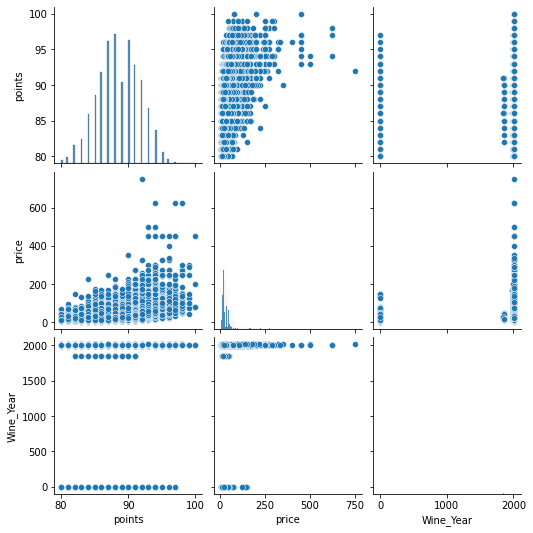

In [336]:
sns.pairplot(full_df[['points','price','Wine_Year']])

In [326]:
def show_random_text(_df,feature,n=1):
    df = _df.sample(n=n,random_state=42)
    print(list(df[feature]))

In [327]:
print_unique_count(us_df_filled)

description has unique values: 50229
designation has unique values: 14131
province has unique values: 16
region_1 has unique values: 16
region_2 has unique values: 18
title has unique values: 50011
variety has unique values: 16
winery has unique values: 5368


## Linear models on numerical data

In [328]:
def add_score(scores_df, score, regressorName, dataType):
    scores_df.loc[regressorName + '_' + dataType, 'r2'] = np.mean(score)

In [329]:
def get_cross_val_score(scores_df,estimator,X_train,y_train,prefix="",sampler=None):
        name = estimator.__class__.__name__
        if estimator.__class__ is Pipeline:
            name = estimator.named_steps['estimator'].__class__.__name__
        pipe = estimator
        sampler_name = ""
        if sampler is not None:
            pipe = make_imb_pipeline(sampler(random_state=42), estimator)
            sampler_name = sampler.__name__
        print('*********' + name + ' ' + sampler_name + '*********')
        score = cross_val_score(
            pipe,
            X_train, 
            y_train, 
            cv=10,
            scoring=('r2'),
            n_jobs = -1
        )
        add_score(scores_df, score, name,prefix)

In [330]:
rergressors = [LinearRegression(),Ridge(),Lasso(),ElasticNet()] 
scores_df = pd.DataFrame(dtype=float)

In [333]:
X_num = get_continuous_features(full_df)
X,y = get_label_and_drop(X_num)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=101,stratify=y)
X_train.describe()

,price,province_America,province_Arizona,province_California,province_Colorado,province_Idaho,province_Michigan,province_Missouri,province_New Mexico,province_New York,...,region_1_Russian River Valley,region_1_Santa Barbara County,region_1_Sonoma Coast,region_1_Sonoma County,region_1_Sta. Rita Hills,region_1_Walla Walla Valley (WA),region_1_Willamette Valley,region_1_Yakima Valley,region_1_other,Wine_Year
count,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,...,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000
mean,36.592830,0.001646,0.000688,0.665119,0.001253,0.003219,0.002162,0.000590,0.000934,0.049142,...,0.056293,0.017839,0.027249,0.022802,0.017396,0.019608,0.042508,0.017814,0.465551,1977.707332
std,25.992290,0.040541,0.026221,0.471955,0.035378,0.056644,0.046450,0.024277,0.030543,0.216168,...,0.230489,0.132367,0.162812,0.149274,0.130745,0.138650,0.201748,0.132277,0.498818,255.090903
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2009.000000
50%,30.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2011.000000
75%,45.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2013.000000
max,750.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2016.000000


In [334]:
for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"numerical")

scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
LinearRegression_numerical,0.290711
Ridge_numerical,0.290717
Lasso_numerical,0.226108
ElasticNet_numerical,0.226190


1.2 Create a simple text-based model using a bag-of-words approach and a linear model.


In [337]:
full_df['description'] = full_df['description'].replace(b"<br />", b" ")

In [338]:
text_trainval = full_df['description'].tolist()
y_trainval = full_df['points']
print("type of text_train: ", type(text_trainval))
print("length of text_train: ", len(text_trainval))
print("class balance: ", np.bincount(y_trainval))

type of text_train:  <class 'list'>
length of text_train:  54264
class balance:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  157  326 1006 1304
 2667 3667 4904 6599 6978 4395 6684 5283 4505 3005 1793  640  221   81
   33   12    4]


In [339]:
text_trainval

['Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.',
 'Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.',
 "Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",
 'Soft, supple plum envelopes an oaky structure in this Cabernet, supported by 15% Merlot. Coffee and chocolate complete the picture, finishing strong at the end, resulting in a value-priced wine of attractive flavor and immediate accessibility.',
 'Slightly reduced, this wine offers a chalky, tannic backbone to an otherwise juicy explosion of rich 

In [340]:
text_train, text_val, y_train, y_val = train_test_split(text_trainval, y_trainval, stratify=y_trainval,random_state=0)

In [341]:
vect = CountVectorizer(stop_words='english',min_df=4)
X_train = vect.fit_transform(text_train)
X_train

<40698x8146 sparse matrix of type '<class 'numpy.int64'>'
	with 959711 stored elements in Compressed Sparse Row format>

In [342]:
print(X_train.shape, y_train.shape)

(40698, 8146) (40698,)


In [343]:
#Vocabulary
feature_names = vect.get_feature_names()
print(feature_names[:10])
print(feature_names[20000:20020])
print(feature_names[::2000])

['000', '02', '03', '04', '05', '06', '07', '08', '09', '10']
[]
['000', 'define', 'larner', 'riverbend', 'wilson']


In [344]:
lr = LogisticRegression(n_jobs=-1).fit(X_train, y_train)
lr.score(X_train,y_train)

0.632561796648484

In [345]:
for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"_count_vectorizer")

scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
LinearRegression_numerical,0.290711
Ridge_numerical,0.290717
Lasso_numerical,0.226108
ElasticNet_numerical,0.226190
LinearRegression__count_vectorizer,0.633880
Ridge__count_vectorizer,0.669190
Lasso__count_vectorizer,-0.000067
ElasticNet__count_vectorizer,-0.000067


1.3 Try using n-grams, characters, tf-idf rescaling and possibly other ways to tune the BoW model. Be aware that you might need to adjust the (regularization of the) linear model for different feature sets.


In [60]:
#your code here

In [346]:
#TfidfVectorizer
tdif = TfidfVectorizer(stop_words='english',min_df=4)
X_train = tdif.fit_transform(text_train)

In [347]:
# lr = LogisticRegression(n_jobs=-1).fit(X_train, y_train)
# lr.score(X_val,y_val)

for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"TfidfVectorizer")

scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
LinearRegression_numerical,0.290711
Ridge_numerical,0.290717
Lasso_numerical,0.226108
ElasticNet_numerical,0.226190
LinearRegression__count_vectorizer,0.633880
Ridge__count_vectorizer,0.669190
Lasso__count_vectorizer,-0.000067
ElasticNet__count_vectorizer,-0.000067
LinearRegression_TfidfVectorizer,0.658178
Ridge_TfidfVectorizer,0.695805


In [348]:
# L1 normalization with CountVectorizer
count_vec = CountVectorizer(stop_words='english',min_df=4)
X_train = count_vec.fit_transform(text_train)
X_train = normalize(X_train,norm="l1")

In [349]:
for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"_CountVectorizer_norma")

scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
LinearRegression_numerical,0.290711
Ridge_numerical,0.290717
Lasso_numerical,0.226108
ElasticNet_numerical,0.226190
LinearRegression__count_vectorizer,0.633880
Ridge__count_vectorizer,0.669190
Lasso__count_vectorizer,-0.000067
ElasticNet__count_vectorizer,-0.000067
LinearRegression_TfidfVectorizer,0.658178
Ridge_TfidfVectorizer,0.695805


In [350]:
#ngrams
ngrm = CountVectorizer(ngram_range=(1, 3), min_df=4,stop_words='english')
X_train = ngrm.fit_transform(text_train)

In [351]:
for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"_ngrm")

scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
LinearRegression_numerical,0.290711
Ridge_numerical,0.290717
Lasso_numerical,0.226108
ElasticNet_numerical,0.226190
LinearRegression__count_vectorizer,0.633880
Ridge__count_vectorizer,0.669190
Lasso__count_vectorizer,-0.000067
ElasticNet__count_vectorizer,-0.000067
LinearRegression_TfidfVectorizer,0.658178
Ridge_TfidfVectorizer,0.695805


In [352]:
cv = CountVectorizer(ngram_range=(1, 3), analyzer="char_wb")
X_train = cv.fit_transform(text_train)
print(f"vocaulary size:{len(cv.vocabulary_)}")

vocaulary size:13248


In [353]:
for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"_char_wb")

scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
LinearRegression_numerical,0.290711
Ridge_numerical,0.290717
Lasso_numerical,0.226108
ElasticNet_numerical,0.226190
LinearRegression__count_vectorizer,0.633880
Ridge__count_vectorizer,0.669190
Lasso__count_vectorizer,-0.000067
ElasticNet__count_vectorizer,-0.000067
LinearRegression_TfidfVectorizer,0.658178
Ridge_TfidfVectorizer,0.695805


In [354]:
scores_df.sort_values(by='r2',inplace=True)
scores_df.tail(5)

,r2
LinearRegression__count_vectorizer,0.633880
LinearRegression_TfidfVectorizer,0.658178
Ridge__count_vectorizer,0.669190
Ridge__char_wb,0.675177
Ridge_TfidfVectorizer,0.695805


1.4 Combine the non-text features and the text features. How does adding those features improve upon just using bag-of-words?

In [355]:
tdif = TfidfVectorizer(stop_words='english',min_df=4)
X_train = tdif.fit_transform(text_train)

ridge = Ridge()
ridge.fit(X_train, y_train)


Ridge()

In [356]:
X_train.shape

(40698, 8146)

In [357]:
def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)

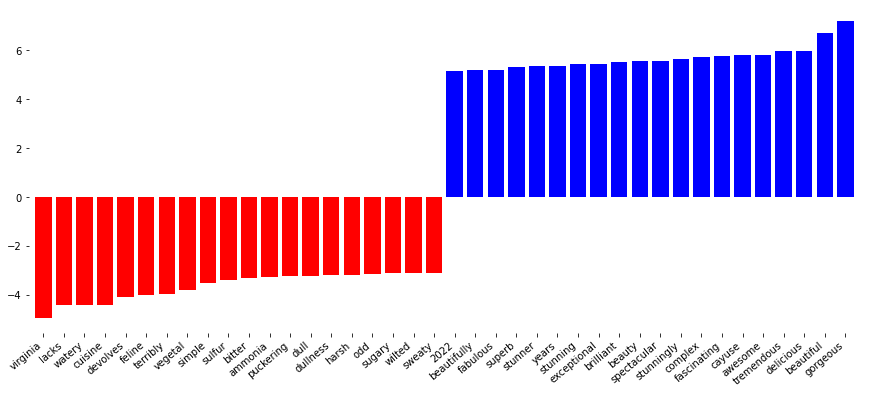

In [358]:
plt.figure(figsize=(15, 6))
plot_important_features(ridge.coef_.ravel(), np.array(tdif.get_feature_names()), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

In [359]:
def get_num_text_pipeline(df,regr_num,regr_text):
    numeric_cols = X_train.columns[X_train.columns.dtype != object].tolist()
    
    transformer_text = FunctionTransformer(lambda x: x['description'], validate=False)
    transfomer_numeric = FunctionTransformer(lambda x: x[numeric_cols], validate=False)

    pipeline = Pipeline([
        ('features', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', transfomer_numeric)
                ])),
                 ('text_features', Pipeline([
                    ('selector', transformer_text),
                    (regr_text.__class__.__name__, regr_text)
                ]))
             ])),
        ('estimator', regr_num)
    ])
    return pipeline

In [362]:
X,y=get_label_and_drop(full_df)

In [363]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=101,stratify=y)

In [364]:
X_train.shape

(40698, 55)

In [365]:
regr_text = TfidfVectorizer(stop_words='english',min_df=4) #TBD try to run on all the text tokenizers

for regr in rergressors:
    pipe = get_num_text_pipeline(X_train,regr,regr_text)
    get_cross_val_score(scores_df,pipe, X_train, y_train,regr_text.__class__.__name__+"_combined")
scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
ElasticNet_TfidfVectorizer,-0.000067
ElasticNet__ngrm,-0.000067
Lasso__ngrm,-0.000067
ElasticNet__CountVectorizer_norma,-0.000067
Lasso__count_vectorizer,-0.000067
ElasticNet__count_vectorizer,-0.000067
Lasso__CountVectorizer_norma,-0.000067
Lasso_TfidfVectorizer,-0.000067
Lasso_numerical,0.226108
ElasticNet_numerical,0.226190


In [366]:
scores_df.sort_values(by='r2',inplace=True)
scores_df.tail(5)

,r2
Ridge__count_vectorizer,0.669190
LinearRegression_TfidfVectorizer_combined,0.670897
Ridge__char_wb,0.675177
Ridge_TfidfVectorizer_combined,0.694224
Ridge_TfidfVectorizer,0.695805


## Task 2 Word Vectors [50pts]

Use a pretrained word-embedding (word2vec, glove or fasttext) for featurization instead of the bag-of-words model. Does this improve classification? How about combining the embedded words with the BoW model?

### spaCy

In [ ]:
#worked for me from shell
pip install -U spacy

In [ ]:
#worked for me from shell
python -m spacy download en_core_web_lg

In [187]:
import spacy

In [188]:
nlp = spacy.load("en_core_web_lg", disable=["tagger", "parser", "ner","lemmatizer"])

In [367]:
X,y=get_label_and_drop(full_df)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=101,stratify=y)

In [368]:
text_trainval = X_train['description'].tolist()
docs_train = [nlp(d).vector for d in text_trainval]
X_train_txt = np.vstack(docs_train)
X_train_txt.shape

(40698, 300)

In [369]:
for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_train_txt, y_train,"word2vec")
scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
ElasticNet_TfidfVectorizer_combined,-0.000095
Lasso_TfidfVectorizer_combined,-0.000095
Lasso_TfidfVectorizer,-0.000067
Lasso__CountVectorizer_norma,-0.000067
ElasticNet__count_vectorizer,-0.000067
ElasticNet_TfidfVectorizer,-0.000067
ElasticNet__CountVectorizer_norma,-0.000067
Lasso__ngrm,-0.000067
ElasticNet__ngrm,-0.000067
Lasso__count_vectorizer,-0.000067


In [370]:
scores_df.sort_values(by='r2',inplace=True)
scores_df.tail(5)

,r2
Ridge__count_vectorizer,0.669190
LinearRegression_TfidfVectorizer_combined,0.670897
Ridge__char_wb,0.675177
Ridge_TfidfVectorizer_combined,0.694224
Ridge_TfidfVectorizer,0.695805


In [371]:
queries = [w for w in nlp.vocab if w.is_lower and w.prob >= -20]

def most_similar(word, count=10):
    by_similarity = sorted(queries, key=lambda w: word.similarity(w), reverse=True)
    return [w.orth_ for w in by_similarity[:count]]

most_similar(nlp("wine"))

['wine',
 'wines',
 'tasting',
 'winery',
 'grape',
 'grapes',
 'beer',
 'tastings',
 'pinot',
 'chardonnay']

### gensim - Doc2Vec

In [ ]:
#worked for me in shell
pip install --upgrade gensim

In [85]:
import gensim

In [372]:
def read_corpus(text, tokens_only=False):
    for i, line in enumerate(text):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(
                gensim.utils.simple_preprocess(line), [i])


            
train_corpus = list(read_corpus(X_train['description']))
test_corpus = list(read_corpus(X_test['description'], tokens_only=True))

model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2)
model.build_vocab(train_corpus)

model.train(train_corpus, total_examples=model.corpus_count, epochs=55)

vectors = [model.infer_vector(train_corpus[doc_id].words)
          for doc_id in range(len(train_corpus))]

X_train = np.vstack(vectors)

X_train.shape

(40698, 50)

In [373]:
for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"gensim")
scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
ElasticNet_TfidfVectorizer_combined,-0.000095
Lasso_TfidfVectorizer_combined,-0.000095
Lasso_word2vec,-0.000095
ElasticNet_word2vec,-0.000095
ElasticNet__count_vectorizer,-0.000067
ElasticNet_TfidfVectorizer,-0.000067
ElasticNet__CountVectorizer_norma,-0.000067
Lasso__ngrm,-0.000067
ElasticNet__ngrm,-0.000067
Lasso__count_vectorizer,-0.000067


In [374]:
scores_df.sort_values(by='r2',inplace=True)
scores_df.tail(5)

,r2
Ridge__count_vectorizer,0.669190
LinearRegression_TfidfVectorizer_combined,0.670897
Ridge__char_wb,0.675177
Ridge_TfidfVectorizer_combined,0.694224
Ridge_TfidfVectorizer,0.695805


### BoW + embedding

In [375]:
X,y=get_label_and_drop(df_text_plus_numeric)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=101,stratify=y)
text_trainval = X_train['description'].tolist()

In [376]:
X_train.shape

(40698, 50)

In [377]:
bow = TfidfVectorizer(stop_words='english',min_df=4)
X_train_bow = bow.fit_transform(text_trainval)
X_train_bow.shape

(40698, 8132)

In [378]:
train_corpus = list(read_corpus(X_train['description']))

doc2vec = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2)
doc2vec.build_vocab(train_corpus)

doc2vec.train(train_corpus, total_examples=doc2vec.corpus_count, epochs=55)

vectors = [doc2vec.infer_vector(train_corpus[doc_id].words)
          for doc_id in range(len(train_corpus))]

X_train_d2v = np.vstack(vectors)
X_train_d2v.shape

(40698, 50)

In [379]:
X_bow_array = X_train_bow.toarray()

In [380]:
X_train_bow_d2v = np.concatenate((X_bow_array,X_train_d2v),axis=1)

In [381]:
for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_train_bow_d2v, y_train,"bow_d2vec")
scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
ElasticNet_TfidfVectorizer_combined,-0.000095
Lasso_TfidfVectorizer_combined,-0.000095
Lasso_word2vec,-0.000095
ElasticNet_word2vec,-0.000095
Lasso_gensim,-0.000095
ElasticNet__count_vectorizer,-0.000067
ElasticNet_TfidfVectorizer,-0.000067
ElasticNet__CountVectorizer_norma,-0.000067
Lasso__ngrm,-0.000067
ElasticNet__ngrm,-0.000067


In [382]:
scores_df.sort_values(by='r2',inplace=True)
scores_df.tail(5)

,r2
LinearRegression_TfidfVectorizer_combined,0.670897
Ridge__char_wb,0.675177
Ridge_TfidfVectorizer_combined,0.694224
Ridge_TfidfVectorizer,0.695805
Ridge_bow_d2vec,0.702069


In [383]:
text_testval = X_test['description'].tolist()

In [384]:
X_test_bow = bow.transform(text_testval)
X_test_bow.shape

(13566, 8132)

In [385]:
test_corpus = list(read_corpus(X_test['description'], tokens_only=True))

test_vectors = [doc2vec.infer_vector(test_corpus[doc_id])
                for doc_id in range(len(test_corpus))]
X_test_doc2vec = np.vstack(test_vectors)
X_test_doc2vec.shape

(13566, 50)

In [386]:
X_test_bow_array = X_test_bow.toarray()
X_test_bow_d2v = np.concatenate((X_test_bow_array,X_test_doc2vec),axis=1)
X_test_bow_d2v.shape

(13566, 8182)

In [387]:
print(X_train_bow.shape)
print(X_test_bow.shape)

(40698, 8132)
(13566, 8132)


In [388]:
best_model = Ridge()
best_model.fit(X_train_bow_d2v,y_train)
best_model.score(X_test_bow_d2v,y_test)

0.7042651836158277

## BoW + doc2vec + numerical

In [389]:
X_train_num_bow_d2v = np.concatenate((drop_columns(X_train,'description'),X_train_bow_d2v),axis=1)
X_test_num_bow_d2v = np.concatenate((drop_columns(X_test,'description'),X_test_bow_d2v),axis=1)

In [390]:
best_model = Ridge()
best_model.fit(X_train_num_bow_d2v,y_train)
best_model.score(X_test_num_bow_d2v,y_test)

0.745585053550047

# Task 3 Transformers (bonus / optional) [50pts] - Like Extra Assignment with 50% weight

Fine-tune a BERT model on the text data alone using the transformers library. How does this model compare to a BoW model, and how does it compare to a model using all features?

In [420]:
from transformers import pipeline
import torch
import transformers
transformers.logging.set_verbosity_info()

In [ ]:
nlp = pipeline("feature-extraction")

In [396]:
X,y=get_label_and_drop(full_df)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=101,stratify=y)
text_trainval = X_train['description'].tolist()
X_train_txt = [nlp(t).vector for t in text_trainval]

In [398]:
X_train_vec = np.vstack(X_train_txt)
X_train_vec.shape

(40698, 300)

In [399]:
for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_train_vec, y_train,"BERT")
scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
LinearRegression_bow_d2vec,-264013664767215968.000000
ElasticNet_TfidfVectorizer_combined,-0.000095
Lasso_TfidfVectorizer_combined,-0.000095
Lasso_bow_d2vec,-0.000095
Lasso_word2vec,-0.000095
ElasticNet_word2vec,-0.000095
Lasso_gensim,-0.000095
ElasticNet__count_vectorizer,-0.000067
ElasticNet_TfidfVectorizer,-0.000067
ElasticNet__CountVectorizer_norma,-0.000067


In [400]:
display(scores_df[scores_df.index.str.contains("BERT")])

,r2
LinearRegression_BERT,0.549454
Ridge_BERT,0.549358
Lasso_BERT,-0.000095
ElasticNet_BERT,-0.000095
